<a href="https://colab.research.google.com/github/kdorichev/course-v3/blob/master/Matrices_Multiplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrices Multiplication Optimization

In [0]:
%matplotlib inline
import torch
import pandas as pd

In [0]:
rows, columns = 10, 1000

In [0]:
m1 = torch.torch.rand(rows,columns)
m2 = torch.torch.rand(columns,rows)

In [4]:
m1[:3,:3]

tensor([[0.3970, 0.4790, 0.2680],
        [0.7339, 0.3108, 0.2608],
        [0.5491, 0.2250, 0.5323]])

In [0]:
times = {}

## PyTorch Matmul as Baseline

In [6]:
# Baseline 
t = %timeit -o -n3 torch.matmul(m1,m2)
times['PyTorch Matmul'] = [t.best, t.worst]

The slowest run took 14.91 times longer than the fastest. This could mean that an intermediate result is being cached.
3 loops, best of 3: 16.7 µs per loop


## Pure Python implementation

In [0]:
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac==br, f"Matrices dimensions mismatch for multiplication: ({a.shape[0],a.shape[1]}*{b.shape[0],b.shape[1]})"
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      for k in range(ac):
        c[i,j] += a[i,k]*b[k,j]
  return c

In [8]:
t= %timeit -o -n3 matmul(m1,m2)
times['Python'] = [t.best, t.worst]

3 loops, best of 3: 1.81 s per loop


## Vectorized algorithm

In [0]:
# Vectorized
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac==br, f"Matrices dimensions mismatch for multiplication: ({a.shape[0],a.shape[1]}*{b.shape[0],b.shape[1]})"
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc): 
        c[i,j] = sum(a[i,:]*b[:,j])
  return c

In [10]:
t= %timeit -o -n3 matmul(m1,m2)
times['Vectorized'] = [t.best, t.worst]

3 loops, best of 3: 421 ms per loop


## Vectorized with Broadcasting algorithm

In [0]:
# Vectorized with broadcasting
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac==br, f"Matrices dimensions mismatch for multiplication: ({a.shape[0],a.shape[1]}*{b.shape[0],b.shape[1]})"
  c = torch.zeros(ar,bc)
  for i in range(ar):
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
  return c

In [12]:
t= %timeit -o -n3 matmul(m1,m2)
times['Vectorized with Broadcasting'] = [t.best, t.worst]

3 loops, best of 3: 640 µs per loop


## Einstein summation algorithm

In [0]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [14]:
t= %timeit -o -n3 matmul(m1,m2)
times['PyTorch Einsum'] = [t.best, t.worst]

The slowest run took 6.89 times longer than the fastest. This could mean that an intermediate result is being cached.
3 loops, best of 3: 36.2 µs per loop


## PyTorch at GPU

In [15]:
if torch.cuda.is_available():
  m3 = m1.cuda()
  m4 = m2.cuda()
  t= %timeit -o -n3 matmul(m3,m4)
  times['PyTorch CUDA'] = [t.best, t.worst]

The slowest run took 12.63 times longer than the fastest. This could mean that an intermediate result is being cached.
3 loops, best of 3: 39 µs per loop


In [31]:
torch.cuda.get_device_name()

'Tesla T4'

In [34]:
torch.cuda.get_device_capability()

(7, 5)

In [39]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)

In [23]:
m3

tensor([[0.3970, 0.4790, 0.2680,  ..., 0.1108, 0.6373, 0.5067],
        [0.7339, 0.3108, 0.2608,  ..., 0.0706, 0.5811, 0.3187],
        [0.5491, 0.2250, 0.5323,  ..., 0.5470, 0.1896, 0.1778],
        ...,
        [0.7367, 0.3813, 0.7823,  ..., 0.6764, 0.6887, 0.8262],
        [0.0457, 0.7883, 0.4293,  ..., 0.4875, 0.5770, 0.3874],
        [0.4143, 0.2305, 0.8778,  ..., 0.2479, 0.1336, 0.3094]],
       device='cuda:0')

## Visualization

In [0]:
df = pd.DataFrame.from_dict(times,orient='index',columns=['best','worst'])
df.sort_values(by='worst', inplace=True)

In [0]:
#df.drop(labels=['best'],axis=1,inplace=True)

Text(0.5, 0, 'Time, msec')

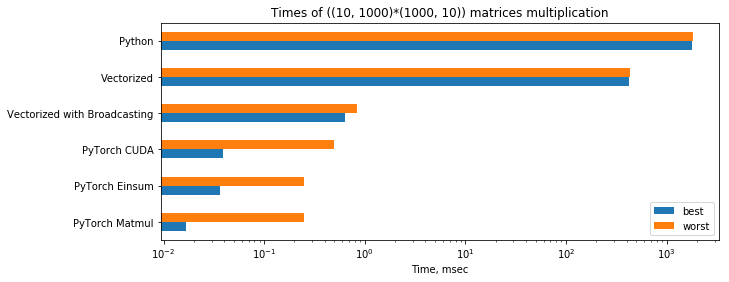

In [18]:
 ax = (df*1000).plot.barh(figsize=(10,4),
                   title=f'Times of ({m1.shape[0],m1.shape[1]}*{m2.shape[0],m2.shape[1]}) matrices multiplication',
                   logx=True, legend=True)
 ax.set_xlabel('Time, msec')